## This Notebook demonstrates how to 
    1) Load an event nexus file.
    2) Normalize buy the proton charge.
    3) Filter events based on entries in the fast log. In this case polarization state.
    4) Extract information for each event and build a string suitable for output to a text file.
    

## The following code block imports the necessary libraries

In [30]:
import sys, math, getopt, os, glob, operator
import numpy as np
import numpy.ma as ma 
np.warnings.filterwarnings('ignore')
#sys.path.append(r'/opt/mantid/bin')
#sys.path.append(r'/Applications/MantidPlot.app/Contents/MacOS')
import mantid
from mantid.simpleapi import *
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mantid import plots

%cd ~

/SNS/users/tc4


## Next we load an event file and prepare a output file for later use. 

In [58]:
#InputFile='/SNS/REF_M/IPTS-16505/data/REF_M_24240_event.nxs'
#InputFile='/SNS/REF_M/IPTS-23097/nexus/REF_M_32328.nxs.h5'
InputFile='/SNS/REF_M/IPTS-23100/nexus/REF_M_32400.nxs.h5'  # has obvious proton flash
OutputFile='000Tof_AbsTime_PixelNo.txt'

if InputFile == None:
    # usage();   sys.exit()
    print("You should provide a valid inputfile if you wish to continue...")
else:
    RawEvents=LoadEventNexus(InputFile)
    RawEvents=Rebin(RawEvents, "2e4, 1., 6e4", PreserveEvents=True) # so that we can plot things in more that one time bin

## Remove the proton flash 

In [ ]:
NoProtonFlash=RemovePromptPulse(RawEvents, Width=300,Frequency=60.0)

### Demonstrate that it worked

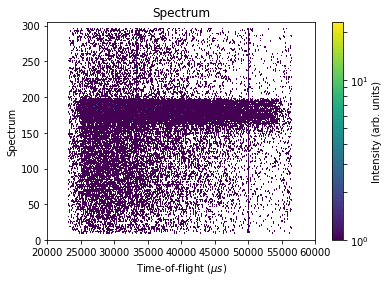

In [60]:
GroupByColumn = CreateGroupingWorkspace(InputWorkspace=RawEvents,FixedGroupCount=304,ComponentName='detector1')
ThetaGrouped = GroupDetectors(RawEvents,CopyGroupingFromWorkspace="GroupByColumn")
#ThetaGrouped=ConvertUnits(ThetaGrouped,Target='Wavelength')
#ThataGrouped=Rebin(ThetaGrouped,(0.01))

fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
c = ax.pcolormesh(ThetaGrouped, norm=LogNorm()) # 
cbar=fig.colorbar(c)
cbar.set_label('Intensity (arb. units)') #add text to colorbar

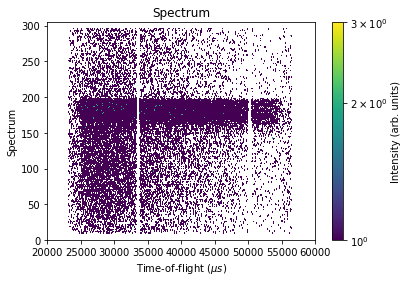

In [61]:
GroupByColumn = CreateGroupingWorkspace(InputWorkspace=NoProtonFlash,FixedGroupCount=304,ComponentName='detector1')
ThetaGrouped = GroupDetectors(NoProtonFlash,CopyGroupingFromWorkspace="GroupByColumn")

fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
c = ax.pcolormesh(ThetaGrouped, norm=LogNorm()) # , norm=LogNorm()
cbar=fig.colorbar(c)
cbar.set_label('Intensity (arb. units)') #add text to colorbar

## Normalize by the proton charge.
This produces a list of events where each event carries a weight and if appropriate an weight error-bar.

Note:

This function calculates event weights and event weight errors based on the integrated good proton charge. This is not a pules by pulse number but one number per run if applied to the entire event list. If applied to a filtered list of events, the "Good Proton Charge" is recalculated so that each filtered list contains its correct fraction of the proton charge.

For experiments that change a parameter faster than the source frequency, we need a different normalization mechanism. We need to normalize each frame to the proton charge in that frame. 

In [12]:
EventsWeightedByProtonCharge=NormaliseByCurrent(InputWorkspace=RawEvents)

## Split out the individual cross sections

In [13]:
def filter_cross_sections(ws):
    """
        Filter events according to an aggregated state log.
        :param str file_path: file to read

        BL4A:SF:ICP:getDI

        015 (0000 1111): SF1=OFF, SF2=OFF, SF1Veto=OFF, SF2Veto=OFF
        047 (0010 1111): SF1=ON, SF2=OFF, SF1Veto=OFF, SF2Veto=OFF
        031 (0001 1111): SF1=OFF, SF2=ON, SF1Veto=OFF, SF2Veto=OFF
        063 (0011 1111): SF1=ON, SF2=ON, SF1Veto=OFF, SF2Veto=OFF
        
        From Mathieu.
    """
    state_log = "BL4A:SF:ICP:getDI"
    states = {'Off_Off': 15,
              'On_Off': 47,
              'Off_On': 31,
              'On_On': 63}
    cross_sections = []

    for pol_state in states:
        try:
            _ws = FilterByLogValue(InputWorkspace=ws, 
                                   LogName=state_log, 
                                   TimeTolerance=0.1,
                                   MinimumValue=states[pol_state],
                                   MaximumValue=states[pol_state],
                                   LogBoundary='Left',
                                   OutputWorkspace='%s_%s'%(ws.getRunNumber(),
                                                            pol_state))
            _ws.getRun()['cross_section_id'] = pol_state
            if _ws.getNumberEvents() > 0:
                cross_sections.append(_ws)
        except:
            mantid.logger.error("Could not filter %s: %s"%(pol_state,
                                                           sys.exc_info()[1]))

    return cross_sections

ListOfFilteredCrossSections=filter_cross_sections(EventsWeightedByProtonCharge)

## Write out the event list to individual text files

In [16]:
Index=0
for X in ListOfFilteredCrossSections:
    Index+=1
    if OutputFile == None:
        OFile = sys.stdout
    else:
        OFile = open(OutputFile+'%d'%(Index), 'w')

    OutList =[] ; OutStrings=[]
    for x in range(256*302):
        f=X.getSpectrum(x)
        tofs=f.getTofs(); PulseTimes = f.getPulseTimes(); 
        Weights=f.getWeights();WeightErrors=f.getWeightErrors()
        for i in range(f.getNumberEvents()): 
            #OutList.append((tofs[i], PulseTimes[i], x, 
            #                Weights[i],WeightErrors[i]))
            OutStrings.append("%s\t%.10f\t%d\t%.10f\t%.10f\n"%(PulseTimes[i],
                               tofs[i], x, Weights[i],WeightErrors[i]))
    
    OutStrings.sort()
    for item in OutStrings: 
        OFile.write(item)

    if OFile is not None:
        OFile.close()

In [18]:
%ls 000*

000Tof_AbsTime_PixelNo.txt1  000Tof_AbsTime_PixelNo.txt2
